In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans

from pyecharts import Bar, Boxplot, Pie, Scatter

import warnings; warnings.filterwarnings(action='ignore')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\lml\utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


### 两个变量之间的关系


散点图
联合分布图
kmeans聚类

In [2]:
class BivariateEDA(object):
    """
    对于dataframe数据中两个字段的数据可视化。
    对于两个类别型（category）数据，可以使用堆叠直方图（plot_stackHist）,，;
    对于数值型（numeric）数据，可以使用联合分布图（plot_joint）
    """
    
    def __init__(self, data):
        """
        数据初始化，必须传入dataframe文件或者文件的有效路径。
        """
        #数值型类型
        self._numeric_type = ['int', 'int32', 'int64', 'float', 'float32', 'float64']
        
        #归一化函数
        self._log_scaler = lambda x: np.log10(x) / np.log10(max(x))
        self._min_max_scaler = lambda x:(x-np.min(x))/(np.max(x) - np.min(x))
        self._z_score_scaler = lambda x: (x - np.mean(x)) / np.std(x)
        self._no_scale = lambda x: x
        
        if isinstance(data, pd.DataFrame):
            self.data = data
        elif isinstance(data,str) and os.path.exists(fpath):
            self.fpath = data
            self.data = self._read_data()
        else:
            print('请输入dataframe文件')
            return 
        return
    
    def _read_data(self):
        """
        如果传入的是文件路径，自动读取文件。
        """
        self.data = pd.read_csv(self.fpath)
        return self.data
    
    def plot_bivariates_bars(self, x_category, y_category, 
                             is_stack=True, bar_category_gap='20%'):
        """
        x_category: 以y_category进行groupby
        y_category:
        
        """

        val = self.data[y_category].unique().tolist()
        bar = Bar(title=y_category, title_pos='center')
        for v in val[::-1]:
            df = self.data[self.data[y_category]==v][[x_category, y_category]].groupby(x_category, as_index = False).count()
            bar.add(name=y_category + '=' + str(v), x_axis=df[x_category], y_axis=df[y_category],
                    is_label_show=True, is_stack=is_stack, bar_category_gap=bar_category_gap,
                    xaxis_name=x_category, xaxis_name_size=16,
                    yaxis_name=y_category, yaxis_name_size=16, yaxis_name_gap=50,
                    legend_pos='right', legend_orient='vertical')
        bar.render()
        return bar
    
    def plot_stackHist(self, x_category, y_category, figsize=(10,6), ylim=None):
        """
        绘制两个类别型字段的堆叠直方图。
        
        x_category: x坐标轴上的类别
        y_category: 在x_category每个类别的分布
        figsize：（x,y）代表图显示的x和y坐标。
        ylim: y轴的坐标限制。

        """

        plt.figure(figsize=figsize, dpi= 80)
        df_agg = self.data.loc[:, [x_category, y_category]].groupby(y_category)
        vals = [df[x_category].values.tolist() for _, df in df_agg]
        colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
        n, bins, patches = plt.hist(vals, 
                                    self.data[x_category].unique().__len__(), 
                                    stacked=True, 
                                    density=False, 
                                    color=colors[:len(vals)])

        plt.legend()
        plt.gca().set(title="Stacked Histogram of %s colored by %s" % (x_category, y_category),
                      xlabel=x_category,
                      ylabel=y_category + '    Frequency',
                      ylim=ylim)
        plt.xticks(ticks=bins, 
                   labels=(self.data[x_category]).unique().tolist(), 
                   rotation=90, 
                   horizontalalignment='left')
        plt.show()
        
    def plot_scatter(self, x_category, y_category, group_category=None, 
                    minMaxScale=False, zScoreScale=False, logScale=False,
                    figsize = (10,6), xlim = None, ylim = None, toIgnoreCate=None,
                    useEcharts=True):
        """
        绘制两个字段间的散点图
        
        x_category: x坐标轴上的类别
        y_category: y坐标轴上的类别
        group_category: 显示在x,y上分布的类别
        figsize：（x,y）代表图显示的x和y坐标。
        xlim: x轴的坐标限制
        ylim: y轴的坐标限制
        toIgnoreCate：不显示的类别
        minMaxScale:对数据进行min-max归一化
        zScoreScale: 对数据进行z-score归一化
        logScale:对数据进行log归一化
        """
        if minMaxScale: 
            scaler = self._min_max_scaler
            scaler.name = 'minMaxScale'
        elif zScoreScale: 
            scaler = self._z_score_scaler
            scaler.name = 'zScoreScale'
        elif logScale:
            scaler = self._log_scaler
            scaler.name = 'logScale'
        else:
            scaler = self._no_scale
            scaler.name = 'noScale'
        if group_category != None:
            categories = np.unique(self.data[group_category])
            colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]
            plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
            for i, c in enumerate(categories):
                if c != toIgnoreCate:
                    data = self.data.loc[self.data[group_category] == c,:]
                    plt.scatter(data[[x_category]].apply(scaler),data[[y_category]].apply(scaler),
                            s=20, color=colors[i], label=c)
        else:
            plt.scatter(self.data[[x_category]].apply(scaler), self.data[[y_category]].apply(scaler))
        plt.gca().set(xlabel=x_category, ylabel=y_category,
                      xlim=xlim, ylim=ylim)
        plt.xticks(fontsize=12, rotation=90);
        plt.yticks(fontsize=12)
        plt.title("Scatterplot of" +  x_category +  "vs" + y_category, fontsize=22)
        plt.legend(fontsize=12,loc = 'upper right')    
        plt.show() 
        
        # 使用pyecharts
        if useEcharts:
            scatter = Scatter(title=x_category +' '+ y_category, title_pos='center')
            scatter.add('', self.data[[x_category]].apply(scaler)[x_category].tolist(),
                        self.data[[y_category]].apply(scaler)[y_category].tolist(),
                        is_visualmap=True, visual_type="size", visual_range_size=[5, 80])
            scatter.render()
            return scatter
    def plot_box(self, x_category, y_category, figsize = (10,6), 
                 minMaxScale=False, zScoreScale=False, logScale=False,
                 ylim = None, add_n_obs_state = False):
        """
        绘制两个类别型字段间的箱型图
        x_category：
        y_category：
        figsize：（x,y）代表图显示的x和y坐标。
        ylim: y轴的坐标限制
        add_n_obs_state：是否显示箱型图中分布的点
        minMaxScale:对数据进行min-max归一化
        zScoreScale: 对数据进行z-score归一化
        logScale:对数据进行log归一化
        """
        plt.figure(figsize = figsize, dpi= 80)
        
        # 数据归一化
        if minMaxScale: 
            scaler = self._min_max_scaler
            scaler.name = 'minMaxScale'
        elif zScoreScale: 
            scaler = self._z_score_scaler
            scaler.name = 'zScoreScale'
        elif logScale:
            scaler = self._log_scaler
            scaler.name = 'logScale'
        else:
            scaler = self._no_scale
            scaler.name = 'noScale'
        if self.data[y_category].dtype in self._numeric_type:
            sns.boxplot(x=self.data[x_category], 
                        y=self.data[[y_category]].apply(scaler).iloc[:,0], 
                        notch=True)
            sns.stripplot(x=self.data[x_category], 
                          y=self.data[[y_category]].apply(scaler).iloc[:,0], 
                          color='black', size=3, jitter=1)

        def add_n_obs(df, group_col, y):
#             medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
            xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
            n_obs = df.groupby(group_col)[y].size().values
            for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
                plt.text(x,0, 
                         "#obs : "+str(n_ob), 
                         rotation = 90,
                         horizontalalignment='left', 
                         fontdict={'size':10}, color='red')
        if add_n_obs_state :
            add_n_obs(self.data, group_col=x_category, y=y_category)
            
        plt.xticks(rotation=90)
        plt.gca().set(title=y_category + '    Box', ylim=ylim)
        plt.show()
        
    def plot_kmeans_cluster(self, x_category, y_category, n_clusters=3, figsize=(10,6), 
                            ylim=None, xlim=None):
        """
        绘制k-means聚类后的数据分布
        
        x_category：
        y_category：
        n_clusters:聚类的簇数量
        figsize：（x,y）代表图显示的x和y坐标。
        xlim: x轴的坐标限制
        ylim: y轴的坐标限制
        """
        tmp = np.array(self.data[[x_category,y_category]])
        kms = KMeans(n_clusters=n_clusters)
        clf = kms.fit_predict(tmp)
        plt.figure(figsize=figsize)
        mark = ['Dr', 'Db', 'Dg', 'Dk', '^b', '+b', 'sb', 'db', '<b', 'pb']
        for i in range(0,len(clf)):
            plt.plot(tmp[i,0],tmp[i,1], mark[clf[i]])
            
        plt.gca().set(xlabel=x_category, ylabel=y_category, 
                      xlim=xlim, ylim=ylim)
        plt.show()
        
    def plot_counts(self, x_category, y_category, delColumn=None, 
                   bigSize=2, figsize=(10,6), xlim=None, ylim=None):
        """
        绘制两个类别型数据间的数量显示
        
        x_category：类别型字段
        y_category：类别型字段
        delColumn: x_category中不显示的字段
        bigSize:放大倍数（数量乘以bigsize是最后的大小）
        figsize：（x,y）代表图显示的x和y坐标。
        xlim: x轴的坐标限制
        ylim: y轴的坐标限制
        """
        fig, ax = plt.subplots(figsize=figsize, dpi=80)
        data_counts = self.data[self.data[x_category]!=delColumn ].groupby([x_category, y_category])\
                            .size().reset_index(name='counts')
        sns.stripplot(x=data_counts[x_category],
                      y=data_counts[y_category], 
                      size=data_counts['counts'] * bigSize, 
                      ax=ax)
        plt.legend(loc='left')
        plt.xticks(rotation = 90)
        plt.gca().set(title = 'Counts Plot ', xlim=xlim, ylim=ylim)
        plt.show()
        
    def plot_categoty_inside(self, x_category, y_category, col_wrap=6,
                             kind='count',figsize=(10,6), dpi=80):
        """
        绘制某一字段内各个类别在另一个类别上的数据统计显示
        
        x_category：类别型字段
        y_category：类别型字段
        col_wrap：每一行显示的小图个数
        kind：显示的类型，‘counts’,'box','violin'等
        figsize：（x,y）代表图显示的x和y坐标。
        """
        
        plt.figure(figsize=figsize, dpi=dpi)
        g = sns.catplot(x=x_category, col=y_category, 
                        col_wrap=col_wrap, data=self.data,
                        kind=kind, height=4, aspect=1, 
                        palette='tab20')
        plt.title(y_category + 'vs' + x_category)
        plt.show()
    
    def plot_ordered_bar(self, x_category, y_category, figsize=(10,6)):
        """
        绘制数值型字段在类别型字段的各个类别上的平均值
        
        x_category：类别型字段
        y_category：数值型字段
        figsize：（x,y）代表图显示的x和y坐标。
        """
        df = self.data[[x_category, y_category]].groupby(x_category).apply(lambda x : x.mean())
        df.sort_values(y_category, inplace=True)
        if self.data[x_category].dtype != 'object':
                df.reset_index(drop=True, inplace=True)
        df.reset_index(inplace=True)
        fig, ax = plt.subplots(figsize=figsize, facecolor='white', dpi= 80)
        ax.vlines(x=df.index, ymin=0, ymax=df[y_category], color='firebrick', alpha=0.7, linewidth=20)

        for i, sim in enumerate(df[y_category]):
            ax.text(i, sim+0.2, round(sim, 1), 
                    horizontalalignment='center',
                    fontdict = {'fontsize':14})

        ax.set_title('Bar Chart for '+y_category, fontdict={'size':22})
        ax.set(ylabel=y_category)
        plt.xticks(df.index, df[x_category], rotation=60, 
                   horizontalalignment='right', fontsize=12)

        p1 = patches.Rectangle((.57, -0.005), width=.33, height=.13, 
                               alpha=.1, facecolor='green', transform=fig.transFigure)
        p2 = patches.Rectangle((.124, -0.005), width=.446, height=.13, 
                               alpha=.1, facecolor='red', transform=fig.transFigure)
        fig.add_artist(p1)
        fig.add_artist(p2)
        plt.show()
        
    def plot_joint(self, x_category, y_category, kind='reg', color='#C44E52',ratio=3,
                   minMaxScale=False, zScoreScale=False, logScale=True,
                   figsize=(10,6), xlim=None, ylim=None):
        """
        绘制两个数值型数据的联合分布
        
        x_category:数值型字段
        y_category: 数值型字段
        kind：‘scatter’‘hex’‘reg’‘kde’
        retio：中心图与侧边的比例
        minMaxScale:对数据进行min-max归一化
        zScoreScale: 对数据进行z-score归一化
        logScale:对数据进行log归一化
        """
        
        plt.figure(figsize=figsize, dpi=80)
         # 数据归一化
        if minMaxScale: 
            scaler = self._min_max_scaler
            scaler.name = 'minMaxScale'
        elif zScoreScale: 
            scaler = self._z_score_scaler
            scaler.name = 'zScoreScale'
        elif logScale:
            scaler = self._log_scaler
            scaler.name = 'logScale'
        else:
            scaler = self._no_scale
            scaler.name = 'noScale'
        if self.data[y_category].dtype in self._numeric_type:
            g = sns.jointplot(self.data[[x_category]].apply(scaler), self.data[[y_category]].apply(scaler),
                              color=color, ratio=3, kind=kind)
        plt.gca().set(xlim=xlim, ylim=ylim,
                     xlabel=x_category, ylabel=y_category)
    
#         plt.title('jointplot of '+ x_category + 'VS'+ y_category, loc='right')
        plt.show()

    def plot_distribution( self, x_category, y_category , size=3, **kwargs, ):
        """
        分布图
        
        x_category: x轴
        y_category: y轴
        row： 横向对比
        col：纵向对比
        """
        row = kwargs.get( 'row' , None )
        col = kwargs.get( 'col' , None )
        facet = sns.FacetGrid(data=self.data, 
                              hue=y_category, 
                              aspect=4, row=row, 
                              col=col,
                              size=size
                             )
        facet.map(sns.kdeplot, x_category, shade= True )
        facet.set(xlim=(0, self.data[x_category].max()))
        facet.add_legend()


### 读取数据



In [14]:
fpath = './data/train.csv'
plotBivar = BivariateEDA(fpath)

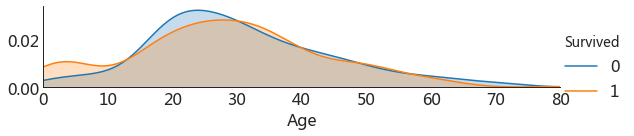

In [16]:
y = 'Survived'
x= 'Age'
plotBivar.plot_distribution(x, y, size=2)

In [5]:
x = 'Pclass'
y = 'Survived'

plotBivar.plot_bivariates_bars(x,y, is_stack=False)

## 堆叠直方图

In [18]:
fpath = './data/data2.csv'
plotBivar = BivariateEDA(fpath)
data = plotBivar.data

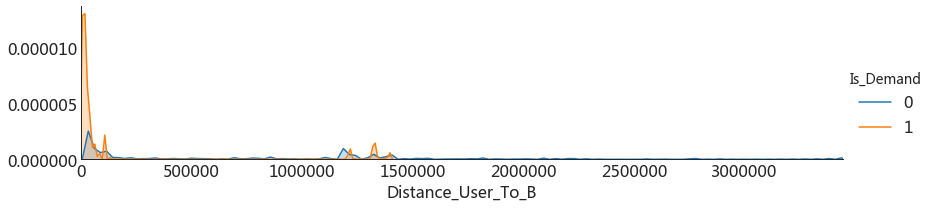

In [19]:
y = 'Is_Demand'
x = 'Distance_User_To_B'
plotBivar.plot_distribution(x, y)

### 散点图

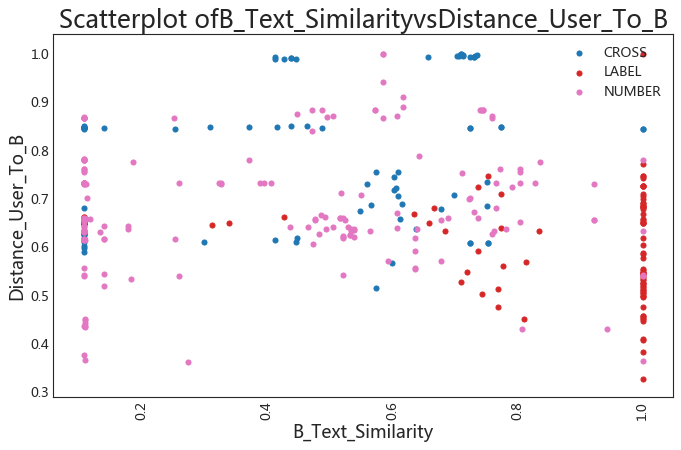

In [20]:
y_category = 'Distance_User_To_B'
x_category = 'B_Text_Similarity'
group_category = 'intention_subject_label'

plotBivar.plot_scatter(x_category, y_category, group_category=group_category, toIgnoreCate='OTHER',logScale=True)
# plotBivar.data.head()
# data= pd.read_csv('./data/data2.csv')
# cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
# sns.scatterplot(data[x_category], data[y_category], pa)
# scatter = Scatter()
# scatter.add('', data[x_category], data[y_category],  group_category=group_category,logScale=True)

## 箱型图

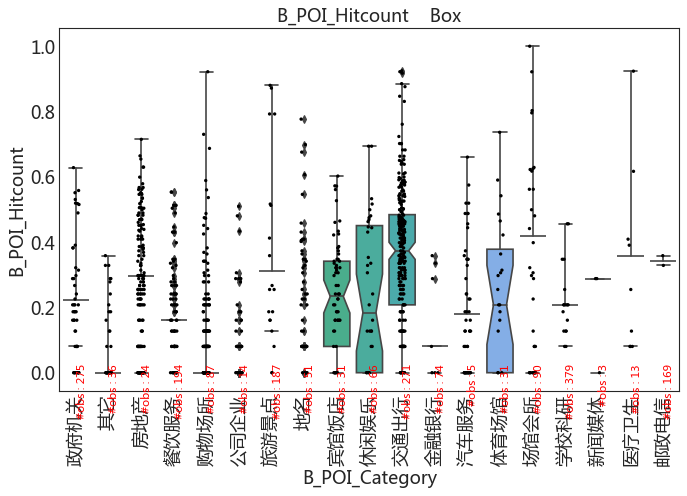

In [21]:
x = "B_POI_Category"
y = "B_POI_Hitcount"
plotBivar.plot_box(x_category = x ,y_category = y, logScale=True, add_n_obs_state=True)


## kmeans 聚类

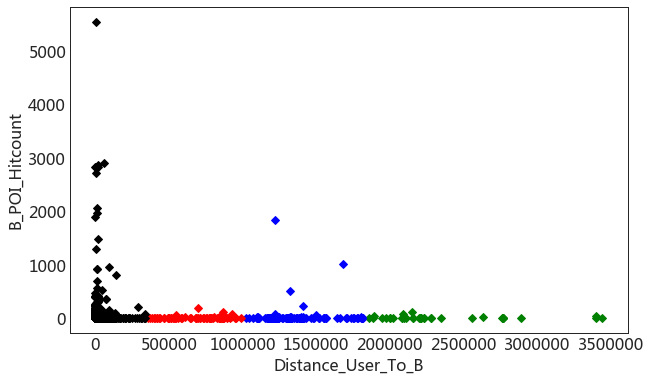

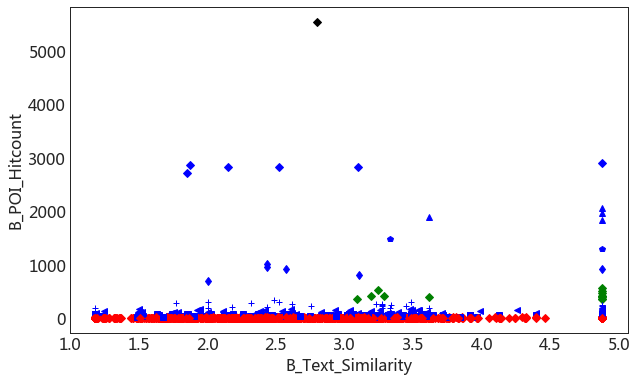

In [22]:
x_category = 'Distance_User_To_B'
y_category = 'B_POI_Hitcount'
plotBivar.plot_kmeans_cluster(x_category, y_category, n_clusters= 4)

x_category = 'B_Text_Similarity'
y_category = 'B_POI_Hitcount'
plotBivar.plot_kmeans_cluster(x_category, y_category, n_clusters = 10)


## count 泡泡图

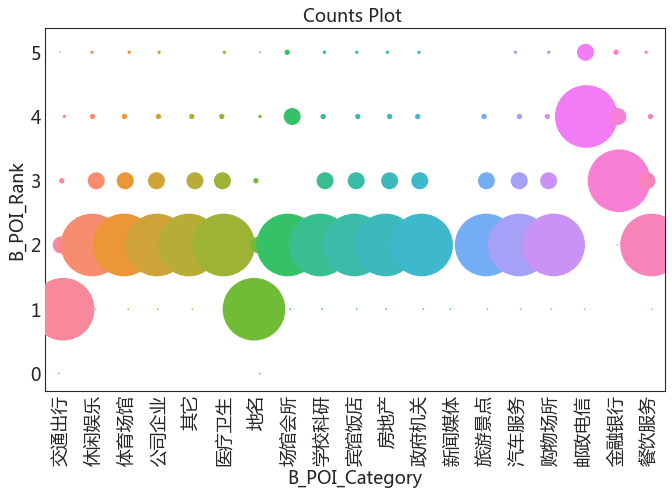

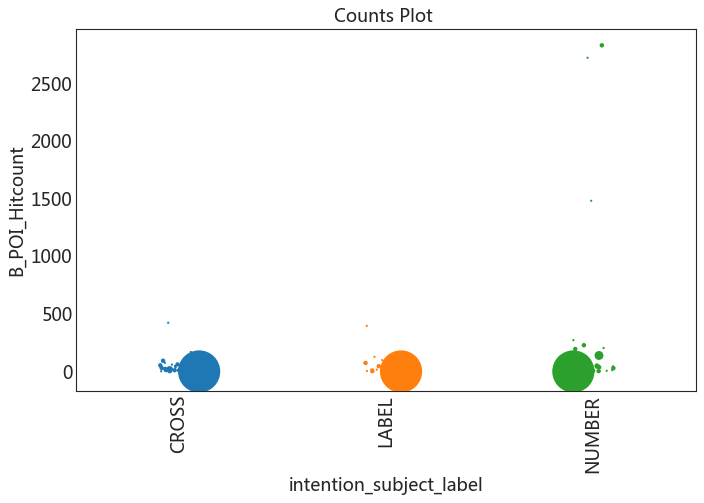

In [11]:
x = 'B_POI_Category'
y = 'B_POI_Rank'
plotBivar.plot_counts( x, y, delColumn=None, bigSize= 0.3)

x = 'intention_subject_label'
y = 'B_POI_Hitcount'
plotBivar.plot_counts(x, y, delColumn='OTHER',bigSize= 2)



### 类别内的数据显示

In [24]:
# plotBivar.plot_categoty_inside( x_category='Survived', y_category='Pclass', 
#                                kind='count', col_wrap=5)

### 排序显示

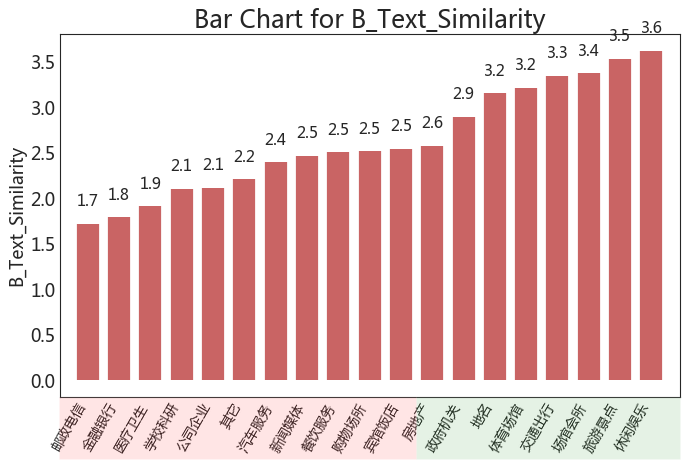

In [31]:
x = 'B_POI_Category' 
y = 'B_Text_Similarity'
plotBivar.plot_ordered_bar(x_category= x, y_category=y)

In [ ]:
# df= pd.read_csv('./data/data2.csv')
# # sns.jointplot(data['Distance_User_To_B'], data['B_POI_Hitcount'])
# # Import Data
# scaler = lambda x: np.log10(x) / np.log10(max(x))

# x = df['Is_Demand']
# y1 = df[['B_POI_Hitcount']]
# y2 = df[['B_POI_Rank']]

# # Plot Line1 (Left Y Axis)
# fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
# ax1.plot(x, y1, color='tab:red')

# # Plot Line2 (Right Y Axis)
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.plot(x, y2, color='tab:blue')

# # Decorations
# # ax1 (left Y axis)
# ax1.set_xlabel('B_POI_Category', fontsize=20)
# ax1.tick_params(axis='x', rotation=0, labelsize=10)
# ax1.set_ylabel('Distance_User_To_B', color='tab:red', fontsize=10)
# ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
# ax1.grid(alpha=.4)

# # ax2 (right Y axis)
# ax2.set_ylabel("# Unemployed (1000's)", color='tab:blue', fontsize=20)
# ax2.tick_params(axis='y', labelcolor='tab:blue')
# ax2.set_xticks(np.arange(0, len(x), 60))
# ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':10})
# ax2.set_title("Personal Savings Rate vs Unemployed: Plotting in Secondary Y Axis", fontsize=22)
# fig.tight_layout()
# plt.show()

In [ ]:
x_category = 'Distance_User_To_B'
y_category = 'B_Text_Similarity'
plotBivar.plot_joint(x_category, y_category)


In [ ]:
# y2.describe()